# Proteome Analysis - norm to total

1. Remove proteins that appear only in one group (only in CC or only in axenic)
2. Impute missing values using low intensity
3. Divide by protein length to normalize by size (optional)
4. Normalize to relative abundance (divide by total abundance) per sample and species 
5. log2 transform
6. compute mean and log2FC between ref and longterm
   (A1, C1 --> C3, C4, C5)
   (P1, C1 --> C3, C4, C5)
7. compute statistics (t-test or Mann-Whitney test)
8. compute FDR

9. goseq - enrichment

 
   




In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

In [2]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [3]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'
HCOLOR = '#E26A2C'
HCOLOR = '#984215'
 
HCOLOR_light = '#FDA65D'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

tpal = brewer.pal(5, "Purples")
gpal = brewer.pal(4, 'Dark2')
ann_colors = list(
    Timepoint = c('1'=tpal[1], '2'=tpal[2], '3'=tpal[3], 
                  '4'=tpal[4], '5'=tpal[5]),
    Group = c(A = HCOLOR_light, C = HCOLOR),
    treatment = c(ref = gpal[2], long.term=gpal[4])
)
#forder = ['med4 (AX)', 'med4 (CC)', '1A3 (CC)', '1A3 (AX)']
#fpal = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  ]


In [4]:
list.files('data')

[1] "Nov22_Processing.xlsx"

In [48]:
P_df = read_excel(file.path('data', 'Nov22_Processing.xlsx'), sheet = 'MED4', na='NaN', .name_repair = "universal")
A_df = read_excel(file.path('data', 'Nov22_Processing.xlsx'), sheet = 'HOT1A3', na='NaN', .name_repair = "universal")
C_df = read_excel(file.path('data', 'Nov22_Processing.xlsx'), sheet = 'Combined', na='NaN', .name_repair = "universal")

New names:
• `Protein Accession` -> `Protein.Accession`
• `Protein Full Name` -> `Protein.Full.Name`
• `Unique Peptides` -> `Unique.Peptides`
• `Sequence Coverage` -> `Sequence.Coverage`
• `Protein Decoy/Contaminant/Target` -> `Protein.Decoy.Contaminant.Target`
• `Number of Peptides` -> `Number.of.Peptides`
• `Number of Unique Peptides` -> `Number.of.Unique.Peptides`
• `Number of PSMs` -> `Number.of.PSMs`
• `Sequence Coverage Fraction` -> `Sequence.Coverage.Fraction`
New names:
• `Protein Accession` -> `Protein.Accession`
• `Protein Full Name` -> `Protein.Full.Name`
• `Unique Peptides` -> `Unique.Peptides`
• `Sequence Coverage` -> `Sequence.Coverage`
• `Protein Decoy/Contaminant/Target` -> `Protein.Decoy.Contaminant.Target`
• `Number of Peptides` -> `Number.of.Peptides`
• `Number of Unique Peptides` -> `Number.of.Unique.Peptides`
• `Sequence Coverage Fraction` -> `Sequence.Coverage.Fraction`
• `Number of PSMs` -> `Number.of.PSMs`
New names:
• `Protein Accession` -> `Protein.Accession`


In [49]:
P_df = P_df %>%
  pivot_longer(cols = starts_with("Intensity_"), names_to = "Sample", names_prefix = "Intensity_", values_to = "Intensity") %>%
  mutate(Sample = str_replace(Sample, "_1", "A")) %>%
  mutate(Sample = str_replace(Sample, "_2", "B")) %>%
  mutate(Sample = str_replace(Sample, "_3", "C")) 

C_df = C_df %>%
  pivot_longer(cols = starts_with("Intensity_"), names_to = "Sample", names_prefix = "Intensity_", values_to = "Intensity") %>%
  mutate(Sample = str_replace(Sample, "_1", "A")) %>%
  mutate(Sample = str_replace(Sample, "_2", "B")) %>%
  mutate(Sample = str_replace(Sample, "_3", "C")) 

A_df = A_df %>%
  pivot_longer(cols = starts_with("Intensity_"), names_to = "Sample", names_prefix = "Intensity_", values_to = "Intensity") %>%
  mutate(Sample = str_replace(Sample, "_1", "A")) %>%
  mutate(Sample = str_replace(Sample, "_2", "B")) %>%
  mutate(Sample = str_replace(Sample, "_3", "C")) 


In [175]:
mdf = bind_rows(P_df, A_df, C_df)


In [176]:
names(mdf)

[1] "Protein.Accession"                "Gene"                            
 [3] "Organism"                         "Protein.Full.Name"               
 [5] "Unique.Peptides"                  "Sequence.Coverage"               
 [7] "Protein.Decoy.Contaminant.Target" "Number.of.Peptides"              
 [9] "Number.of.Unique.Peptides"        "Number.of.PSMs"                  
[11] "Sequence.Coverage.Fraction"       "Sample"                          
[13] "Intensity"

In [177]:
mdf = mdf %>% extract('Protein.Accession', into='Species.long', regex='\\[([^\\]]+)\\]$', remove = FALSE)


In [178]:
species_map = c(
    'Prochlorococcus marinus' = 'PRO',
    'Alteromonas' = 'ALT', 
    'Alteromonas macleodii' = 'ALT',
    'Prochlorococcus'= 'PRO', 
    'Gammaproteobacteria' = 'ALT',
    'Alteromonas/Salinimonas group' = 'ALT', 
    'Alteromonadaceae' = 'ALT',
    'Cyanobacteria'= 'PRO', 
    'Alteromonas sp. 07-89-2' = 'ALT', 
    'Alteromonadales' = 'ALT'
)
#mdf['Species'] = mdf['Protein Accession'].str.extract(r'\[([^\]]+)\]$')[0].map(species_map)
#species_map[mdf$Species_long]

In [179]:
mdf = mdf %>% mutate(Species = species_map[mdf$Species.long])

In [180]:
mdf = mdf %>% mutate(protein_id = word(Protein.Accession, 1))

In [181]:
mdf = mdf %>% 
   mutate(Group = substr(mdf$Sample, 1,1)) %>%
   mutate(timepoint = substr(mdf$Sample, 2,2)) %>%
   mutate(replicate = substr(mdf$Sample, 3,3)) %>%
   mutate(Group.timepoint = substr(mdf$Sample, 1,2)) 

In [182]:
cmap = c(A='Axenic', P='Axenic', C='Co-culture')
mdf = mdf %>% 
   mutate(Culture = cmap[Group]) 



In [183]:
mdf = mdf %>% mutate(viable_sample = !(Group.timepoint %in% c('A5', 'P5', 'P3')))

In [184]:
head(mdf)

Protein.Accession                                                       
1 WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]
2 WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]
3 WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]
4 WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]
5 WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]
6 WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]
  Species.long            Gene Organism Protein.Full.Name
1 Prochlorococcus marinus NA   NA       NA               
2 Prochlorococcus marinus NA   NA       NA               
3 Prochlorococcus marinus NA   NA       NA               
4 Prochlorococcus marinus NA   NA       NA               
5 Prochlorococcus marinus NA   NA       NA               
6 Prochlorococcus marinus NA   NA       NA               
  Unique.Peptides                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [185]:
# look for proteins in both conditions
found_proteins_df = mdf %>% 
  drop_na(Intensity) %>%
  filter(viable_sample) %>% 
  count(Culture, Protein.Accession) %>% 
  count(Protein.Accession) %>%
  filter(n==2)
  


In [186]:
found_proteins_df

Protein.Accession,n
<chr>,<int>
P00760,2
P00761,2
P01031,2
P02533,2
P02538,2
P02768,2
P02769,2
P04264,2
P05787,2


In [187]:
mdf = mdf %>% mutate(found_proteins = Protein.Accession %in% found_proteins_df$Protein.Accession)

In [188]:
mdffound = mdf %>% 
  filter(found_proteins ==TRUE, Species %in% c('ALT', 'PRO')) 


In [204]:
mdffound = mdffound %>% 
  mutate(Imputed_Intensity = replace_na(mdffound$Intensity, min(mdffound$Intensity, na.rm = TRUE) / 2))

In [205]:
mdffound %>%
   group_by(Species, Sample) %>%
   summarise(min(Imputed_Intensity, na.rm = TRUE))

`summarise()` has grouped output by 'Species'. You can override using the `.groups` argument.


Species,Sample,"min(Imputed_Intensity, na.rm = TRUE)"
<chr>,<chr>,<dbl>
ALT,A1A,1503.475
ALT,A1B,1503.475
ALT,A1C,1503.475
ALT,A2A,1503.475
ALT,A2B,1503.475
ALT,A2C,1503.475
ALT,A3A,1503.475
ALT,A3B,1503.475
ALT,A3C,1503.475


In [200]:
min(mdffound$Intensity, na.rm = TRUE)

[1] 3006.95

In [206]:
mdffound$log2Intensity = log2(mdffound$Imputed_Intensity)

In [207]:
#mdf['relative_Abundance'] = 
mdffound = mdffound %>% 
  group_by(found_proteins, Species, Sample) %>% 
  mutate(relative_Abundance = 100*Imputed_Intensity / sum(Imputed_Intensity))


Warning message:
“Removed 3808 rows containing missing values (geom_point).”


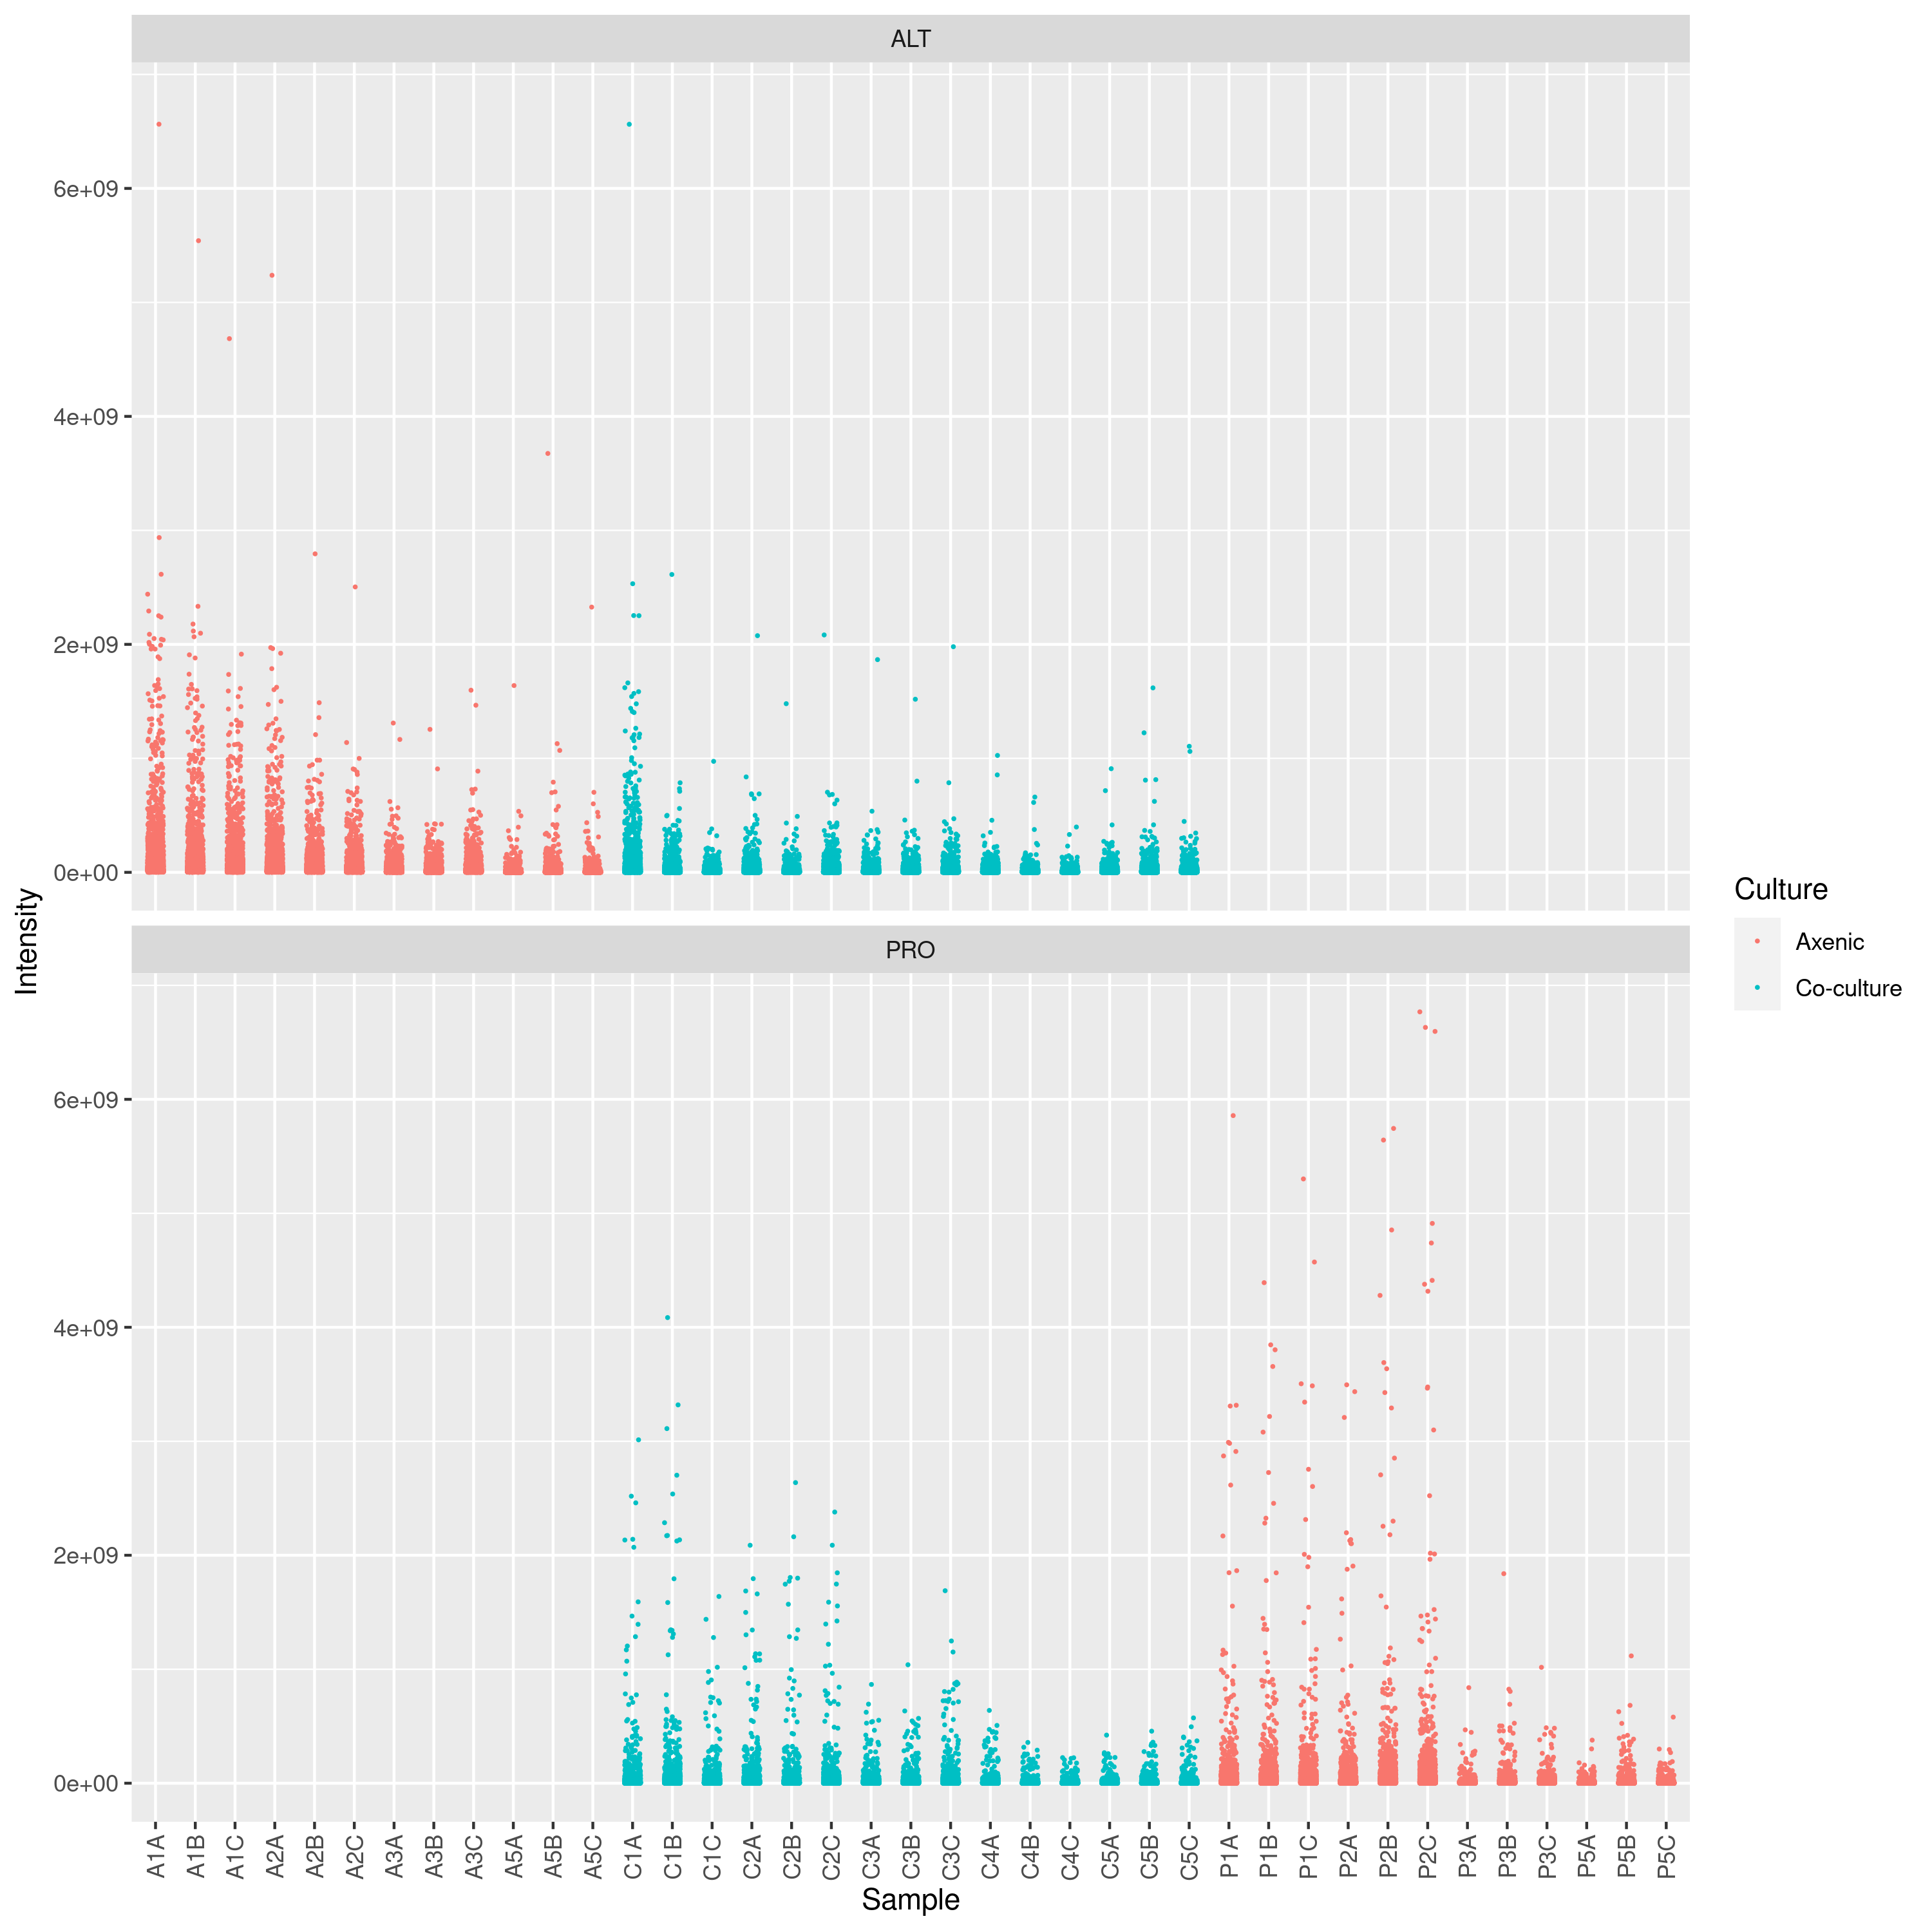

In [208]:
mdffound %>%
  #filter(found_proteins ==TRUE, Species %in% c('ALT', 'PRO')) %>%
  ggplot(aes(y=Intensity, x=Sample, color=Culture)) +
  geom_jitter(position=position_jitter(0.2), size=0.2) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  facet_wrap(~Species, ncol = 1)

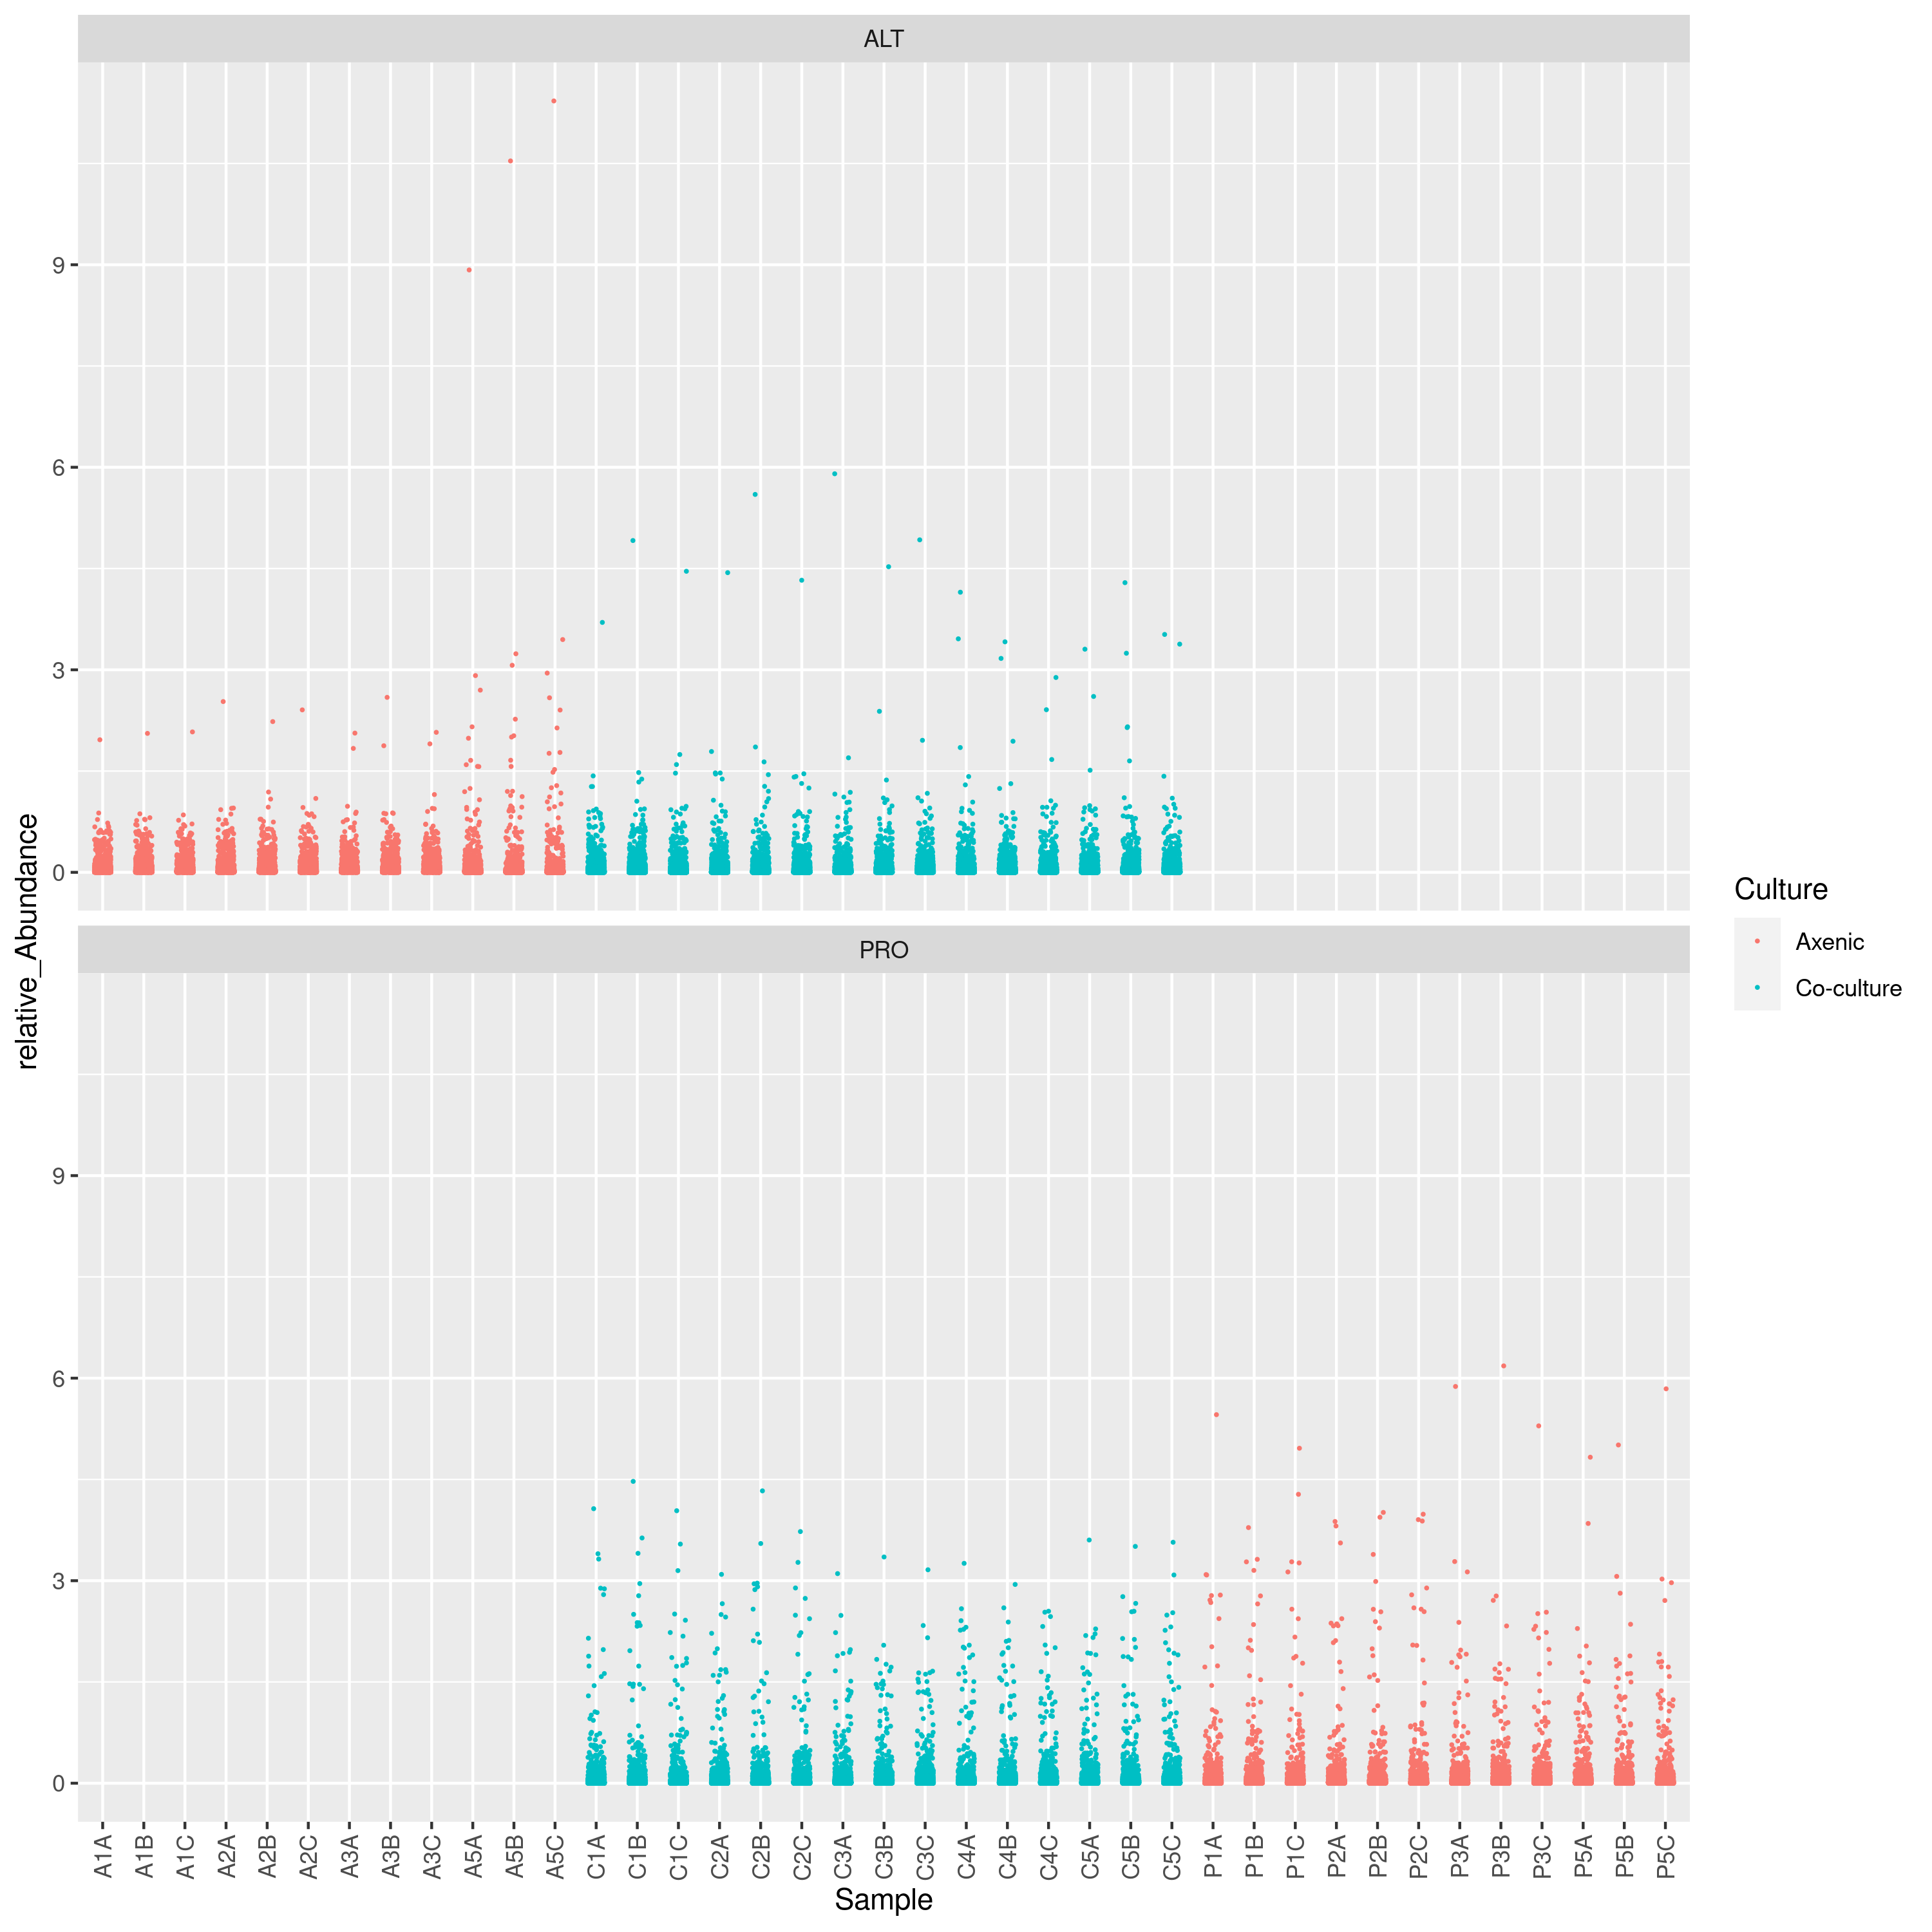

In [211]:
mdffound %>%
  filter(found_proteins ==TRUE, Species %in% c('ALT', 'PRO')) %>%
  ggplot(aes(y=relative_Abundance, x=Sample, color=Culture)) +
  geom_jitter(position=position_jitter(0.2), size=0.2) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  facet_wrap(~Species, ncol = 1)

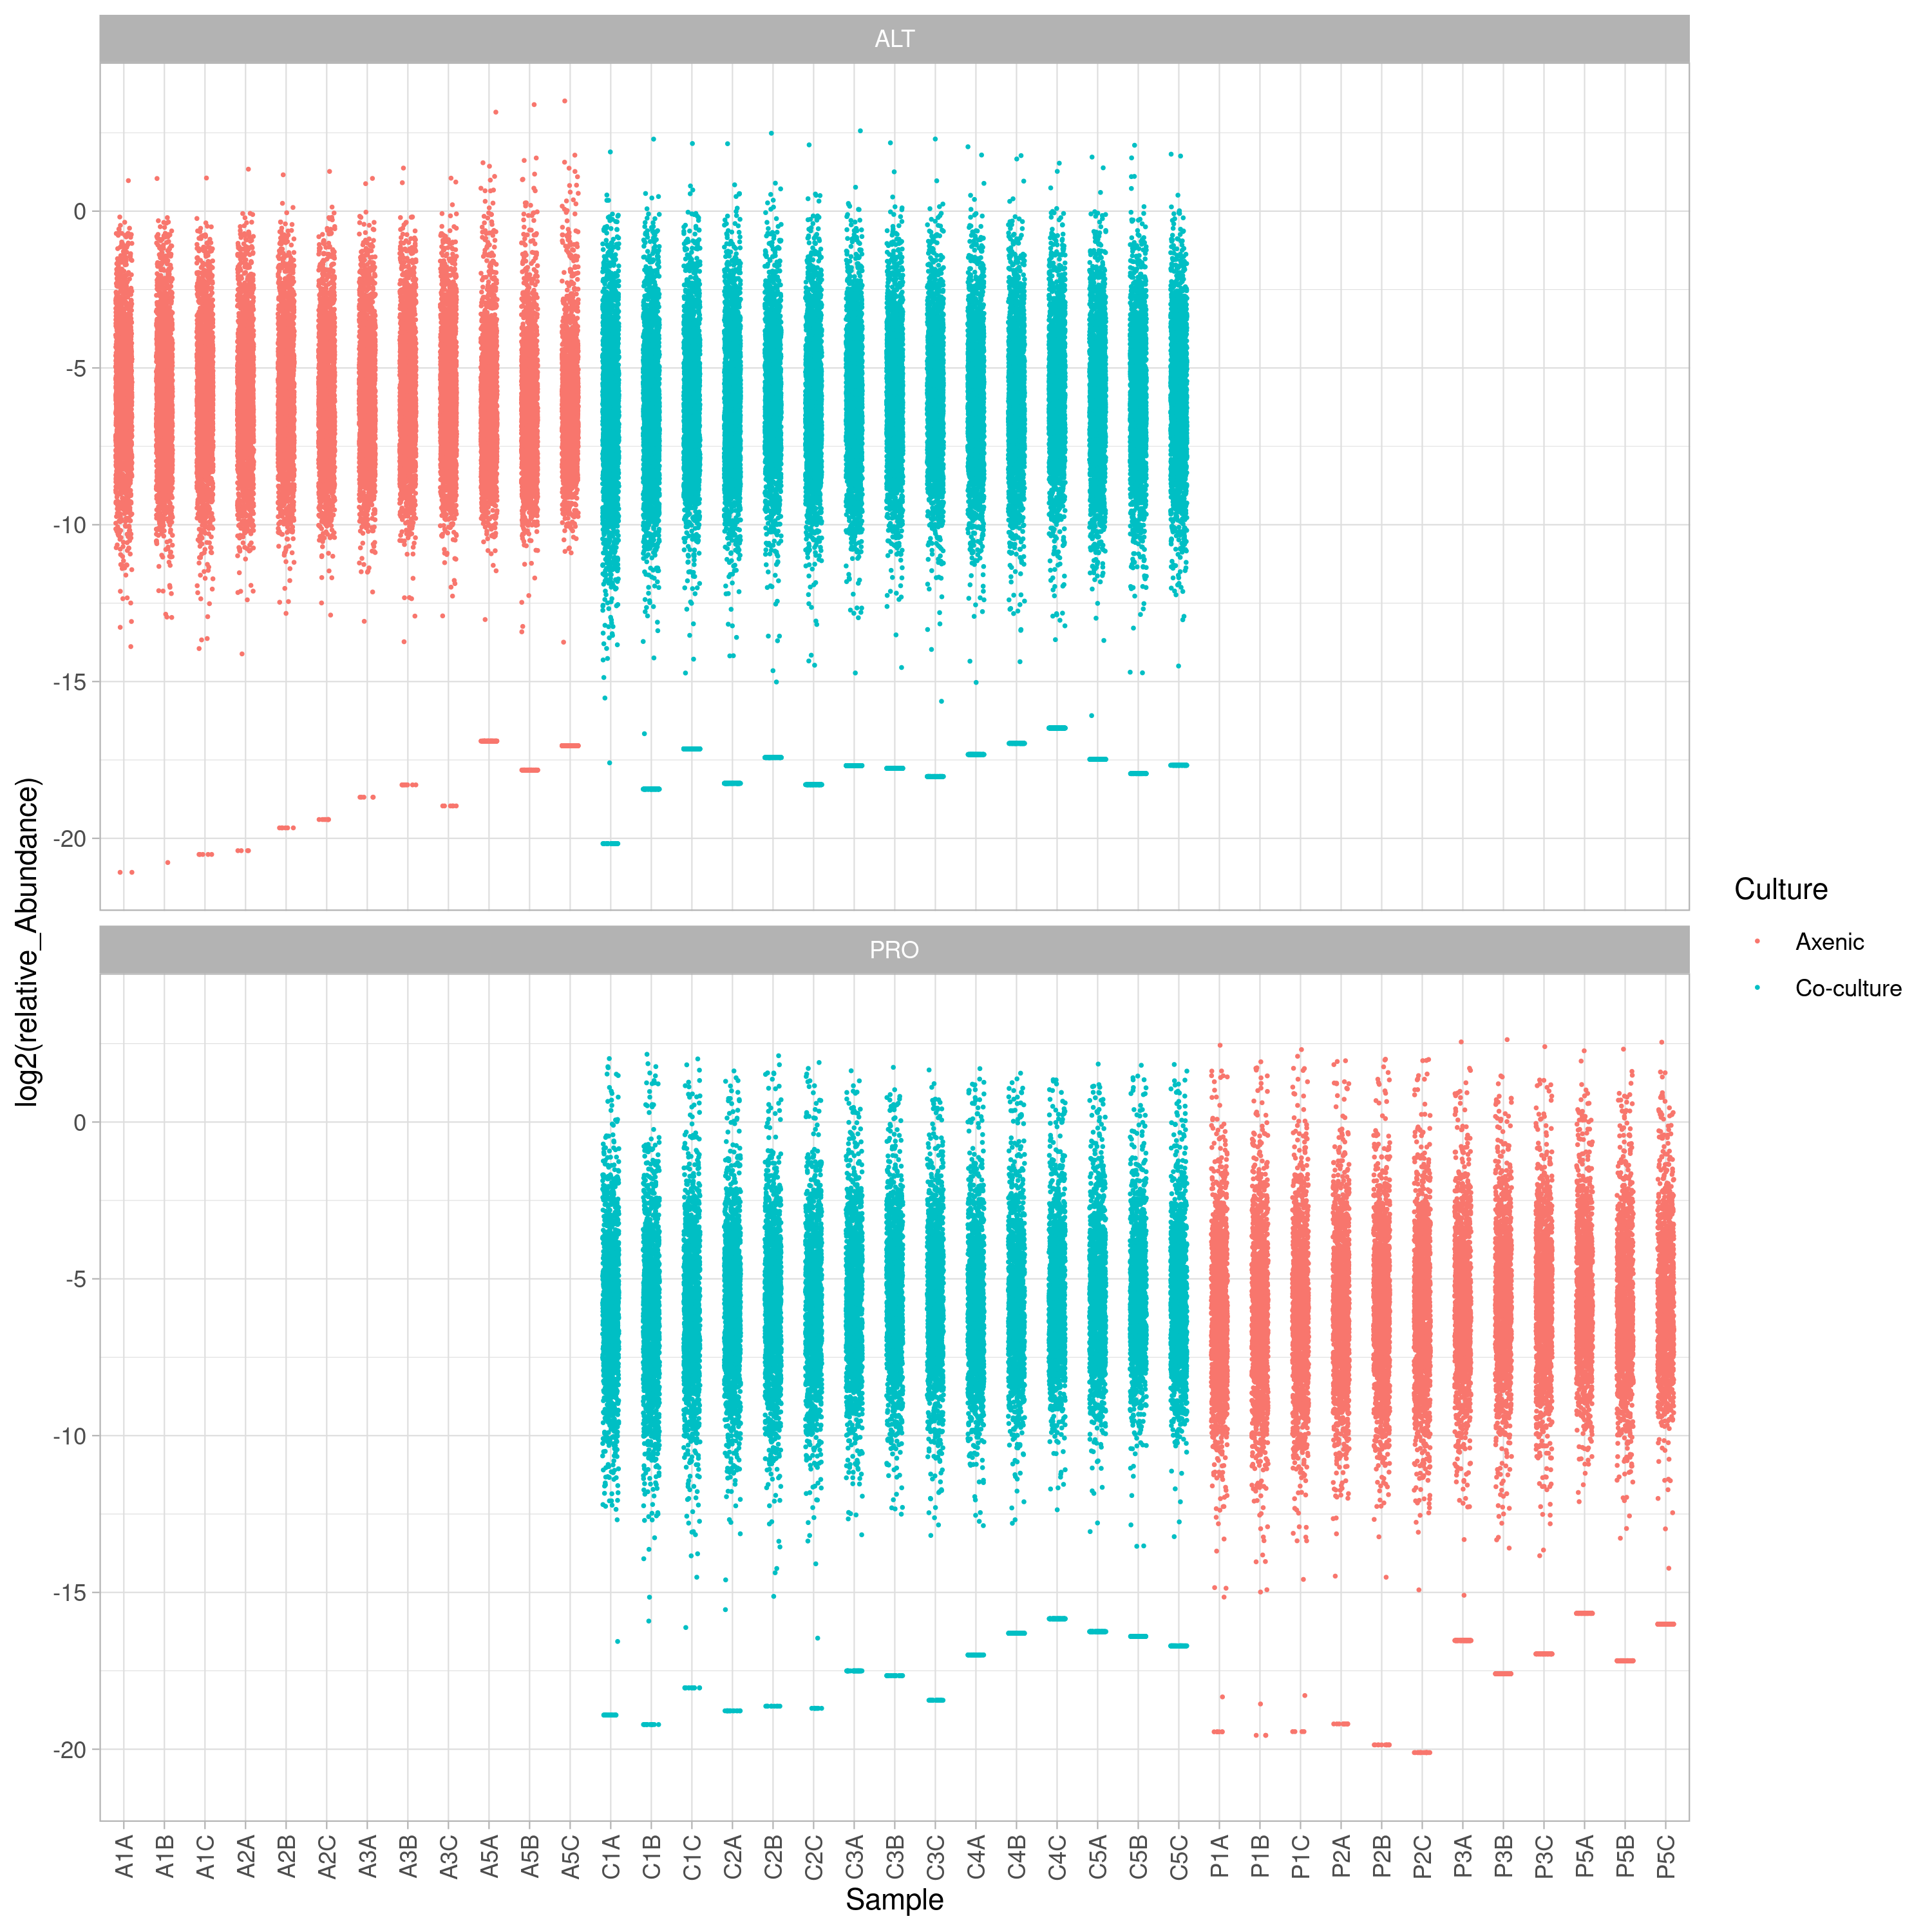

In [209]:
mdffound %>%
  filter(found_proteins ==TRUE, Species %in% c('ALT', 'PRO')) %>%
  ggplot(aes(y=log2(relative_Abundance), x=Sample, color=Culture)) +
  geom_jitter(position=position_jitter(0.2), size=0.2) +
  theme_light() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  facet_wrap(~Species, ncol = 1)